## Урок 2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск

In [10]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [11]:
num_samples = 500
num_features = 1
b = 10
random_state = 24
noise = 100

X, y, coef = datasets.make_regression(n_samples=num_samples,
                                      n_features=num_features,
                                      n_informative=num_features,
                                      bias=b,
                                      coef=True,
                                      random_state=random_state,
                                      noise=noise)

# Добавим единичный столбец к датасету для
# подбора веса для свободного члена
x_ones = np.ones(num_samples)
X = np.hstack((x_ones[:, np.newaxis], X))

print(X.shape)
print(y.shape)
print(coef)

(500, 2)
(500,)
75.90728241077991


In [12]:
def compare_models(*models):
    fig = plt.figure(figsize=(20, 10))

    # Построение полученных моделей и сравнение с идеальным решением
    plt.subplot(211)
    plt.scatter(X[:, 1], y)
    plt.plot(X[:, 1], coef * X[:, 1] + b, label="true line")
    for model in models:
        plt.plot(X[:, 1], model.W[1] * X[:, 1] + model.W[0], label=model.name)
    plt.legend(loc="best")

    # Построение зависимости функции ошибки от эпохи для каждой модели
    plt.subplot(223)
    for model in models:
        plt.plot(model.loss_history, label=f"{model.name} loss")
    plt.xlabel("epochs", size=14)
    plt.ylabel("loss", size=14)
    plt.legend(loc="best")

    # Зависимость весов моделей от эпохи и сравнение с весами идеального решения
    plt.subplot(224)
    max_epochs = 0
    for model in models:
        max_epochs = max(max_epochs, len(model.wts_history))

        epochs = np.arange(len(model.wts_history))
        plt.scatter(epochs, model.wts_history[:, 0],
                    label=f"{model.name} w0", marker=".")
        plt.scatter(epochs, model.wts_history[:, 1],
                    label=f"{model.name} w1", marker=".")

    plt.scatter(np.arange(max_epochs), np.repeat(b, max_epochs), label="real w0", marker=".")
    plt.scatter(np.arange(max_epochs), np.repeat(coef, max_epochs), label="real w1", marker=".")
    
    plt.xlabel("epochs", size=14)
    plt.ylabel("weights", size=14)
    plt.legend(loc="best")

In [13]:
class TrainModel:
    def __init__(self, name, X, y, epochs, lr,
                 is_SGD, l1_lambda=None, l2_lambda=None):
        self.name = name
        self.X = X
        self.y = y
        self.epochs = epochs
        self.lr = lr
        self.is_SGD = is_SGD
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
    
    def calc_mse(self):
        W = self.W
        y_pred = self.X @ W
        # функция ошибки - MSE
        loss = np.mean((self.y - y_pred) ** 2)
        if self.l1_lambda:
            # при l1 регуляризации добавляем к лоссу сумму модулей весов
            l1_loss = np.sum(np.abs(W))
            loss += self.l1_lambda * l1_loss
        if self.l2_lambda:
            # при l2 регуляризации добавляем к лоссу сумму квадратов весов
            l2_loss = np.sum(W ** 2)
            loss += self.l2_lambda * l2_loss
        return loss

    def grad_step(self, X, y_true):
        W = self.W
        # Производная MSE
        grad = 2 / len(y_true) * X.T @ (X @ W - y_true)
        if self.l1_lambda:
            # Производная модуля весов сводится к знаку каждого веса
            grad += self.l1_lambda * np.sign(W)
        if self.l2_lambda:
            # Производная квадрата весов сводится к 2 * вес
            grad += self.l2_lambda * 2 * W
        return grad

    def train(self):
        if self.is_SGD:
            print("training with SGD...")
        else:
            print("training with GD...")
        
        self.W = np.array([5., 10.])
        self.loss_history = []
        self.wts_history = [self.W.copy()]
        epoch = 0

        min_weight_dist = 1e-7 # критерий остановки обучения
        weight_dist = np.inf

        while weight_dist > min_weight_dist and epoch < self.epochs:
            if self.is_SGD:
                idx = np.random.randint(0, len(self.y))
                y_grad = self.y[[idx]]
                X_grad = self.X[[idx]]
            else:
                y_grad = self.y
                X_grad = self.X
            
            self.W -= lr * self.grad_step(X_grad, y_grad)
            weight_dist = np.linalg.norm(self.wts_history[-1] - self.W, ord=2)

            loss = self.calc_mse()
            
            self.loss_history.append(loss)
            self.wts_history.append(self.W.copy())

            if epoch % 1000 == 0:
                print(epoch, self.W, loss)
            
            epoch += 1

        self.wts_history = np.vstack(self.wts_history)
        
        print(f"stop training on {epoch} epoch")

training with GD...
0 [ 5.01034638 10.1237416 ] 13787.925268174915
1000 [11.04140049 64.18223262] 9942.467903279732
2000 [12.48437052 71.77371625] 9865.063906060454
3000 [12.7677992 72.8466913] 9863.470980368733
4000 [12.81863238 72.99926444] 9863.437591183998
5000 [12.8272881  73.02108163] 9863.436880959198
6000 [12.82871381 73.02421742] 9863.436865678657
7000 [12.82894335 73.02467023] 9863.43686534704
stop training on 7274 epoch
training with SGD...
0 [5.35604532 9.42009016] 13871.880447389587
1000 [11.57538603 67.01894151] 9899.97195389
2000 [11.75220835 69.80077748] 9874.561825360526
3000 [12.3047295 75.6115026] 9870.429818024564
4000 [17.83253056 73.77207703] 9888.708378574722
5000 [13.6252652  74.70014611] 9866.728752482484
6000 [14.81873161 70.74740703] 9872.896309715386
7000 [ 8.18588807 67.37231096] 9914.315659718644
8000 [10.41938713 75.14018847] 9874.089210479633
9000 [ 7.05463845 78.21160806] 9925.855912253488
10000 [ 9.53876268 70.3094335 ] 9880.78602715437
11000 [12.94171

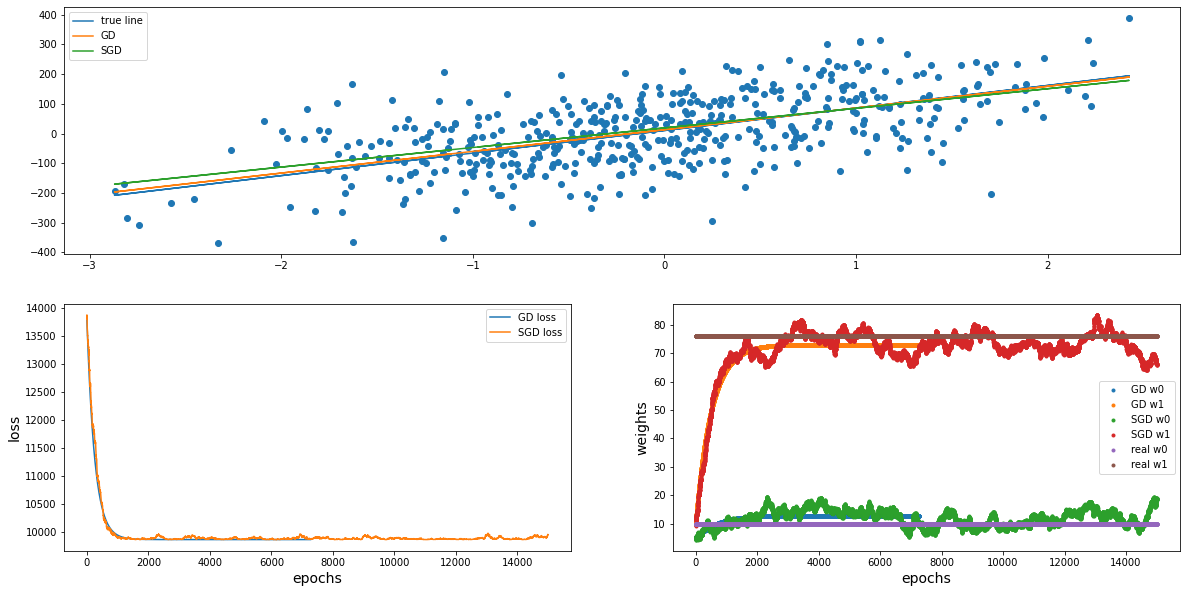

In [14]:
epochs = 15000
lr = 1e-03

GD_model = TrainModel("GD", X, y, epochs, lr, is_SGD=False)
GD_model.train()

SGD_model = TrainModel("SGD", X, y, epochs, lr, is_SGD=True)
SGD_model.train()

compare_models(GD_model, SGD_model)

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

training with GD...
0 [ 5.01024638 10.1235416 ] 13789.226888111607
1000 [10.94833424 63.72106519] 9992.728262947854
2000 [12.34510789 71.09801311] 9919.329488426834
3000 [12.61434422 72.11991831] 9917.8786220948
4000 [12.66170431 72.26233861] 9917.849410122448
5000 [12.66961175 72.28229892] 9917.848813239014
6000 [12.67088871 72.28511077] 9917.848800902731
7000 [12.67109025 72.28550873] 9917.848800645546
stop training on 7198 epoch
training with SGD...
0 [ 5.06651324 10.09348116] 13792.36151194988
1000 [11.07006475 67.15840005] 9945.953091641073
2000 [ 8.75556878 68.71950542] 9944.834675954677
3000 [14.38028351 63.9781593 ] 9990.796805179172
4000 [18.23743039 69.46472842] 9958.398381031448
5000 [12.08415129 73.49054057] 9919.703873512964
6000 [11.53705269 69.00227923] 9929.580859597681
7000 [13.98819907 79.94855932] 9977.291004863338
8000 [16.11281783 74.16339736] 9932.783184031277
9000 [ 9.65658645 67.17892981] 9951.72737629463
10000 [17.62871378 76.1196297 ] 9955.725092588951
11000 [

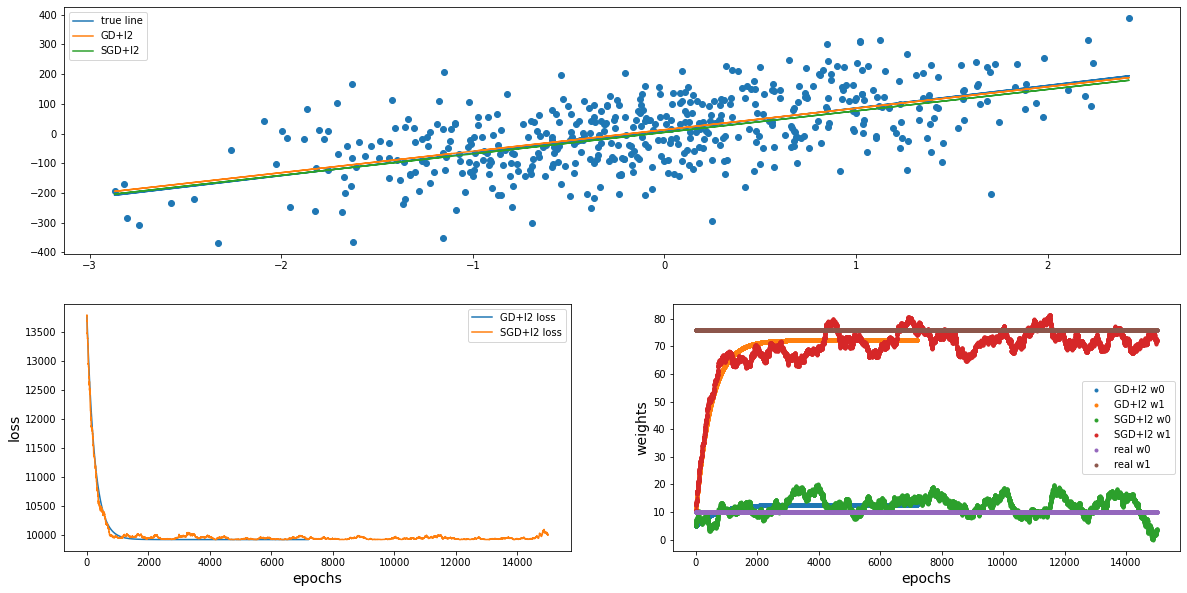

In [15]:
epochs = 15000
lr = 1e-03
l2_lambda = 0.01

GD_l2_model = TrainModel("GD+l2", X, y, epochs, lr, is_SGD=False, l2_lambda=l2_lambda)
GD_l2_model.train()

SGD_l2_model = TrainModel("SGD+l2", X, y, epochs, lr, is_SGD=True, l2_lambda=l2_lambda)
SGD_l2_model.train()

compare_models(GD_l2_model, SGD_l2_model)

3 [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

training with GD...
0 [ 5.01033638 10.1237316 ] 13788.077947198248
1000 [11.0369453  64.17773825] 9943.310462989195
2000 [12.47926089 71.76854648] 9865.922033173689
3000 [12.76259305 72.84141999] 9864.329457136266
4000 [12.81341197 72.99397789] 9864.296075779674
5000 [12.82206559 73.01579279] 9864.295365729733
6000 [12.82349098 73.01892824] 9864.295350453092
7000 [12.82372047 73.019381  ] 9864.295350121562
stop training on 7274 epoch
training with SGD...
0 [4.70277545 9.97803579] 13809.357347933723
1000 [14.13386271 60.7595303 ] 10015.70594861877
2000 [15.01949253 70.35957509] 9876.591262810993
3000 [11.01271371 68.6264726 ] 9885.950739363534
4000 [10.86390279 75.79782152] 9876.213690626044
5000 [11.48738566 81.46313906] 9937.395811679386
6000 [15.396808   74.00346143] 9871.658128958568
7000 [14.98630411 75.13305653] 9872.995608990628
8000 [15.91123667 71.54131983] 9876.3687852628
9000 [ 8.76913976 72.54249948] 9880.796855095303
10000 [14.95117513 65.79894589] 9921.569946116188
11000 [

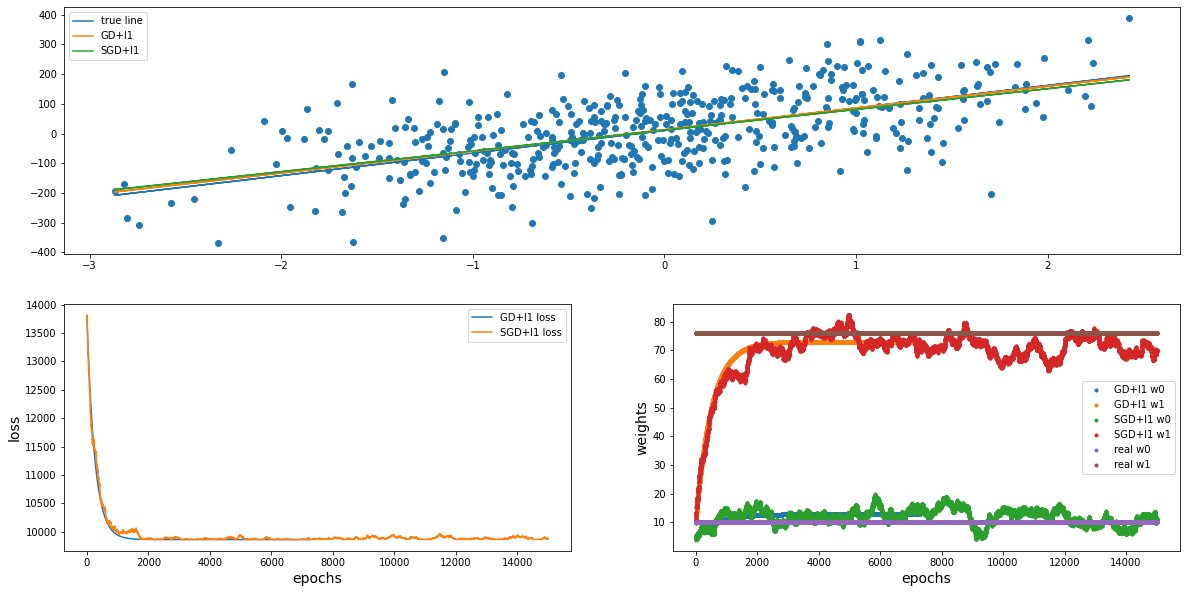

In [16]:
epochs = 15000
lr = 1e-03
l1_lambda = 0.01

GD_l1_model = TrainModel("GD+l1", X, y, epochs, lr, is_SGD=False, l1_lambda=l1_lambda)
GD_l1_model.train()

SGD_l1_model = TrainModel("SGD+l1", X, y, epochs, lr, is_SGD=True, l1_lambda=l1_lambda)
SGD_l1_model.train()

compare_models(GD_l1_model, SGD_l1_model)

Сравним модели обученные градиентным спуском без регуляризации, с l1 регуляризацией и с l2 регуляризацией

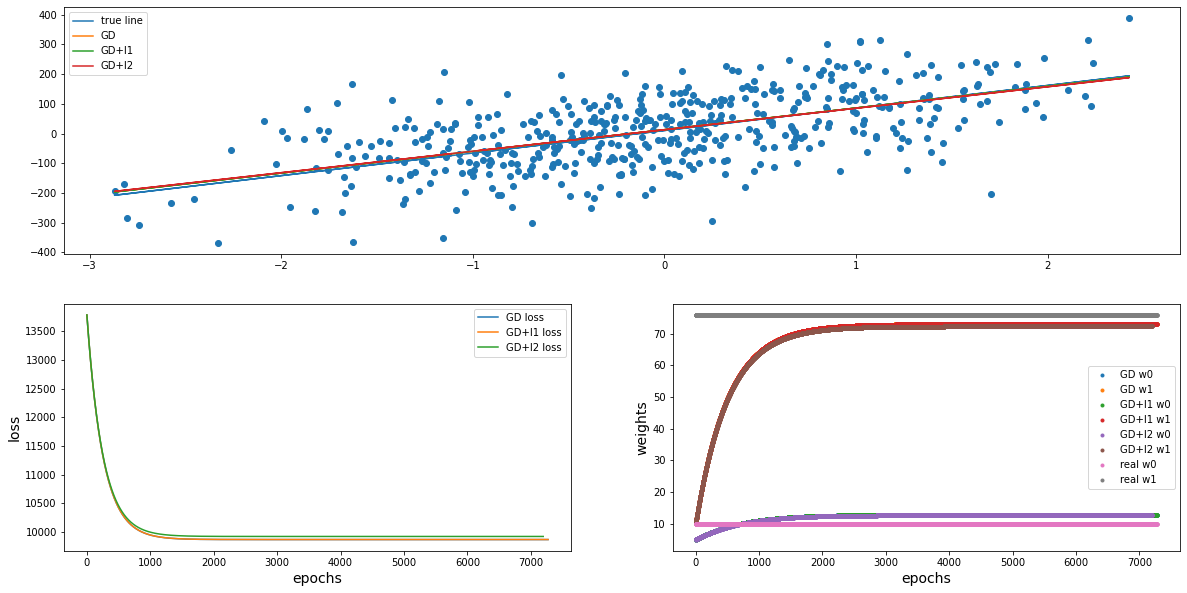

In [17]:
compare_models(GD_model, GD_l1_model, GD_l2_model)

Сравним модели обученные стохастическим градиентным спуском без регуляризации, с l1 регуляризацией и с l2 регуляризацией

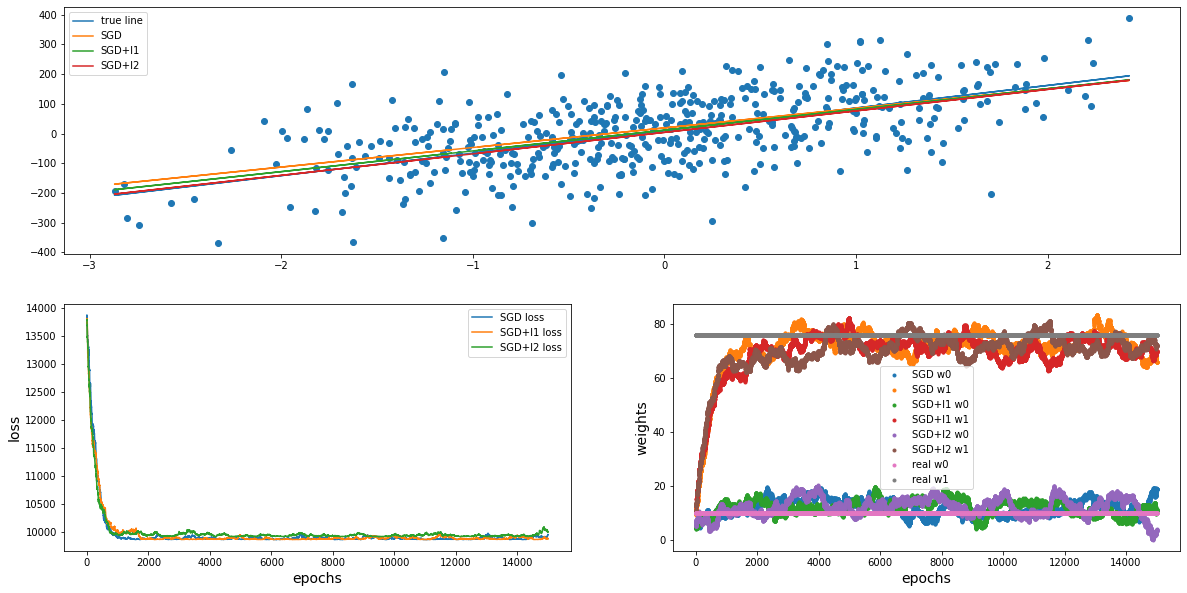

In [18]:
compare_models(SGD_model, SGD_l1_model, SGD_l2_model)

## Выводы
Все модели сошлись, но модели обученные с помощью стохастического градиентного спуска не достигают заданного нами качества. Но все же разница крайне мала и не существенна.

В принципе все результаты получились очень схожими, возможно проблема в том, что исходный датасет очень простой.